# PREDICTIVE YIELD CURVE MODELING
<i>An Application of Principal Component Analysis to euro yield curves</i>
***
The term structure of interest rates (“yield curve”) is a representation that plots bonds of the same type (e.g. credit quality, sector) in terms of their prices, expressed as yields, over different maturity dates. This project sets out to study the yield curve dynamics in reduced dimensionality. In literature Principal Component Analysis (PCA) is a known application to this use case.

<u>After a successful yield curve decomposition the following topics will be tackled:</u>
- Supporting the interpretation of the first 3 principal components (PCs) in accordance with traditional (shift,slope,curvature) factors
- Testing out-of-sample fit for model yield curves, generated from reduced principal components set
- Derivation of non-linear stress scenarios for each component (1-month ahead 95% confidence)
- Testing predictability with an autoregressive timeseries model

The underlying data represents Euro area AAA government spot rate yield curves. They have been retrieved for a time horizon starting from 01-01-2015 to 31.12.2020 on a daily basis.

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import sys
root = os.environ['HOME']+"/private/pca-yield-curve-analytics/"
sys.path.append(root)

from src.utils import calc_rmse, std_scale_pandas, adf_test, rainbow

In [2]:
plt.rcParams.update({'font.size': 8})

### Rates
***

In [3]:
df       = pd.read_csv("../assets/rates_clean.csv", index_col="DATE", parse_dates=["DATE"])
df_train = pd.read_csv("../assets/train.csv", index_col="DATE", parse_dates=["DATE"])
df_test  = pd.read_csv("../assets/test.csv", index_col="DATE", parse_dates=["DATE"])

maturities = ["3M", "1Y", "5Y", "10Y", "20Y"]
maturities_all = df.columns

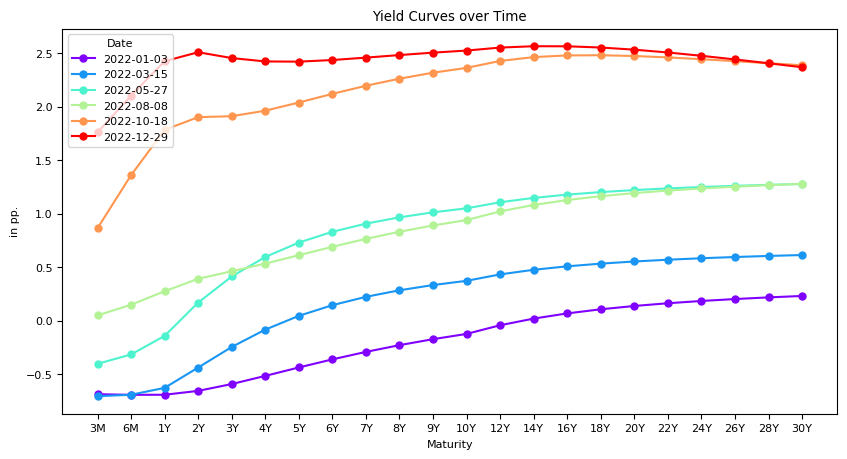

In [4]:
dates = df[::len(df)//5].index

# Depict yield curves per each observed year end
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(dates)

for i,j in enumerate(dates):
    ax.plot(df.loc[j], marker="o", markersize=5, c=color[j], label=j.date())

ax.set_title ("Yield Curves over Time")
ax.set_xlabel ("Maturity")
ax.set_ylabel ("in pp.")
ax.legend(title="Date", loc="upper left")

plt.show()

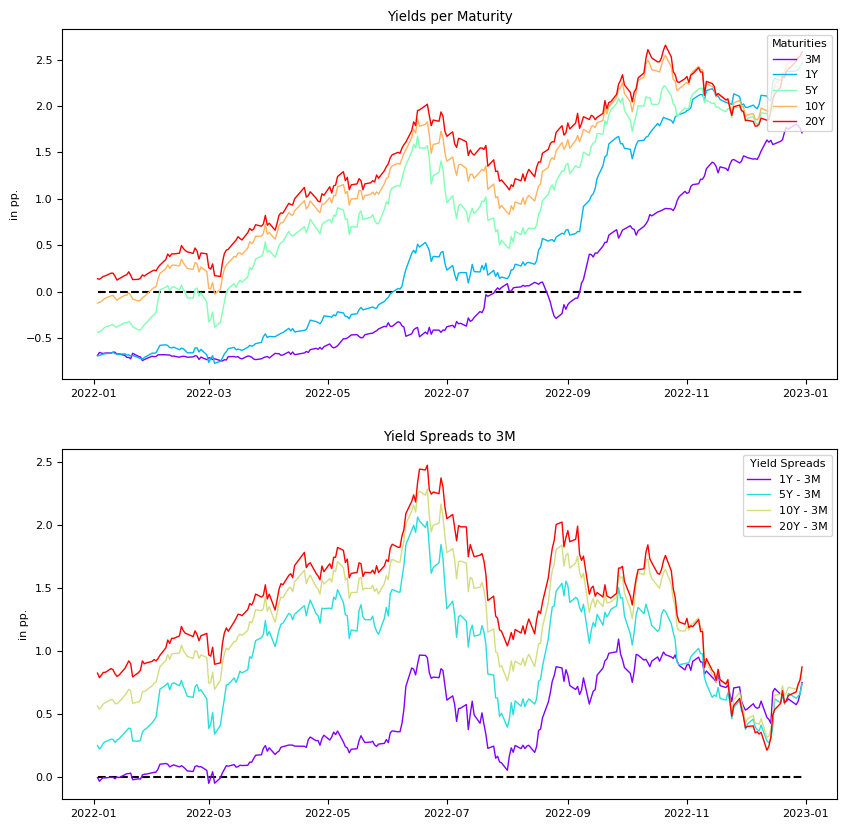

In [5]:
# Depicting yields for various maturities over time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (10,10))

color_1 = rainbow(maturities)
color_2 = rainbow(maturities[1:])

# Subplot #1
for i in maturities: 
    ax1.plot (df[i], c=color_1[i], label=i, linewidth=1)

ax1.hlines(
    y=0, 
    xmin=min(df.index), 
    xmax=max(df.index), 
    colors="black", 
    linestyles="dashed"
)

# Subplot #2
for i in maturities[1:]: 
    plt.plot (df[i]-df.iloc[:,0], c=color_2[i], label= i+" - 3M", linewidth=1)
     
ax2.hlines(
    y=0,
    xmin=min(df.index), 
    xmax=max(df.index), 
    colors="black", 
    linestyles="dashed", 
    label=""
)

ax1.set_title ("Yields per Maturity")
ax2.set_title ("Yield Spreads to 3M")
ax1.set_ylabel ("in pp.")
ax2.set_ylabel ("in pp.")
ax1.legend(title = "Maturities", loc = "upper right")
ax2.legend(title = "Yield Spreads", loc = "upper right")
plt.show()

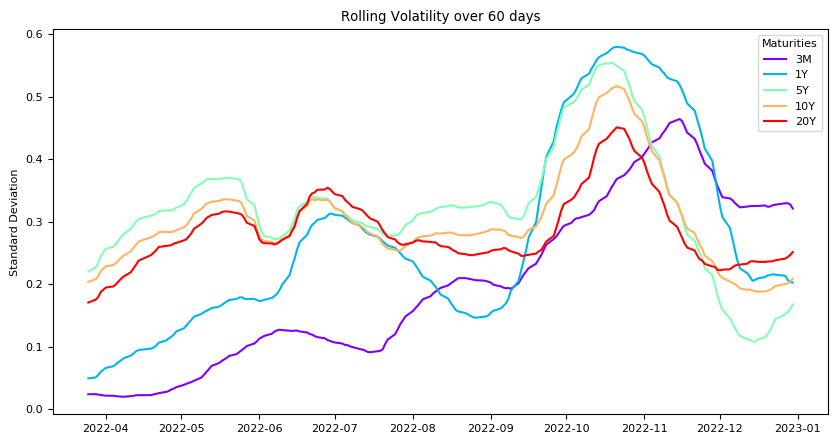

In [6]:
# Insert time window for rolling volatility (in units of previously defined frequency)
roll_window = 60
roll_vola = df.rolling(roll_window).std().iloc[roll_window-1:]

# Depicting rolling volatility for various maturities over time
fig, ax = plt.subplots(figsize=(10,5))

for i in maturities:
    ax.plot(roll_vola[i], c=color_1[i], label=i)

ax.set_title (f'Rolling Volatility over {roll_window} days')
ax.set_ylabel ("Standard Deviation")
ax.legend(title="Maturities", loc="upper right")
plt.show()

### Eigenvectors & Eigenvalues
***

In [7]:
pca = joblib.load("../assets/pca.joblib")
pca.__dict__.keys()

dict_keys(['df', 'maturities', 'k', 'cov_matr', 'idx', 'eig_vals', 'eig_vect', 'eig_vect_k', 'eig_scores', 'eig_scores_k', 'eig_vect_inv', 'eig_vect_inv_k', 'rates'])

In [8]:
eig_vectors   = pca.eig_vect_k
eig_values    = pca.eig_vals
eig_scores    = pca.eig_scores_k
pca_rates     = pca.rates
pca_rates_oos = pca.backtrans_oos(df_test)
pcs           = pca.idx[:pca.k]

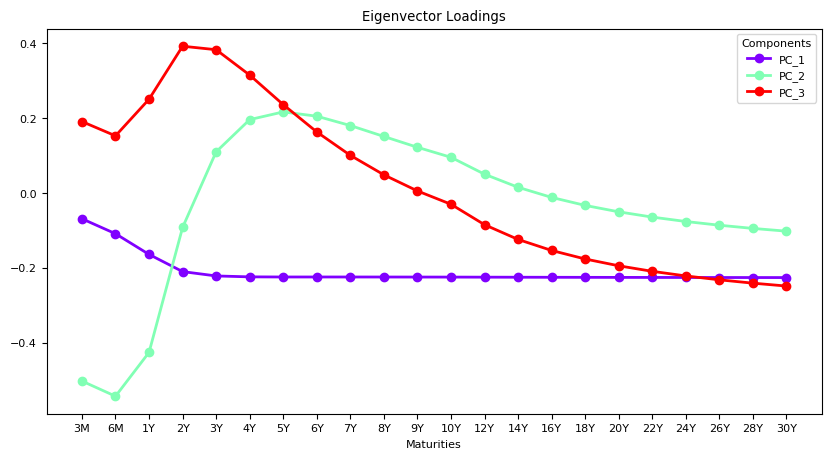

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(np.linspace(0,1,3)).values()

for (name, val), c in zip(eig_vectors.items(), color):
    ax.plot(val, c=c, label=name, linewidth=2, marker="o")

ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

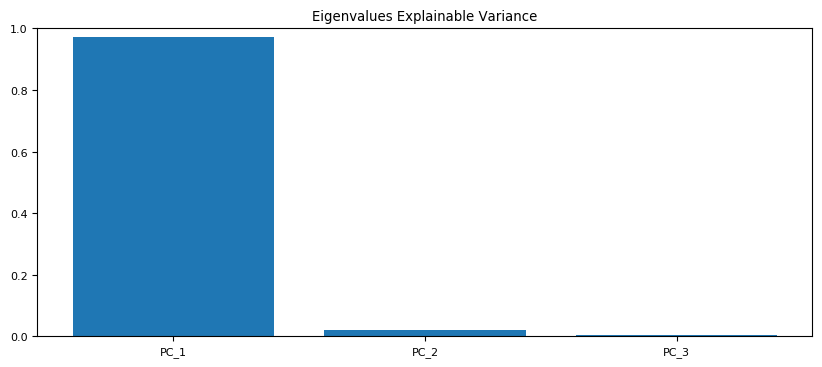

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(
    eig_values.index[:pca.k], 
    eig_values["eig_val_rel"][:pca.k]
)

ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")
plt.show()

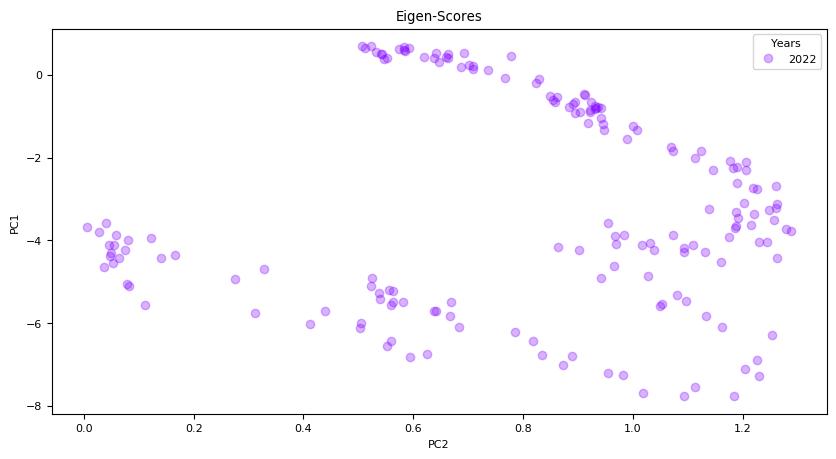

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

color = rainbow(set(eig_scores.index.year))
eig_scores_by_year = eig_scores.groupby(eig_scores.index.year)

for year, data in eig_scores_by_year:
    ax.plot(
        data["PC_2"].values, 
        data["PC_1"].values, 
        c=color[year], 
        marker="o", 
        linestyle="", 
        alpha=0.3, 
        label=year
    )

ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")
plt.show()

### Yield Curve Factors
***

In [12]:
eig_scores_scaled = std_scale_pandas(eig_scores)

# Classical yield curve factors
level = std_scale_pandas(df_train["10Y"])*-1
slope = std_scale_pandas(df_train["10Y"] - df_train["6M"])
curve = std_scale_pandas(df_train["6M"] + df_train["10Y"] - 2*df_train["5Y"])

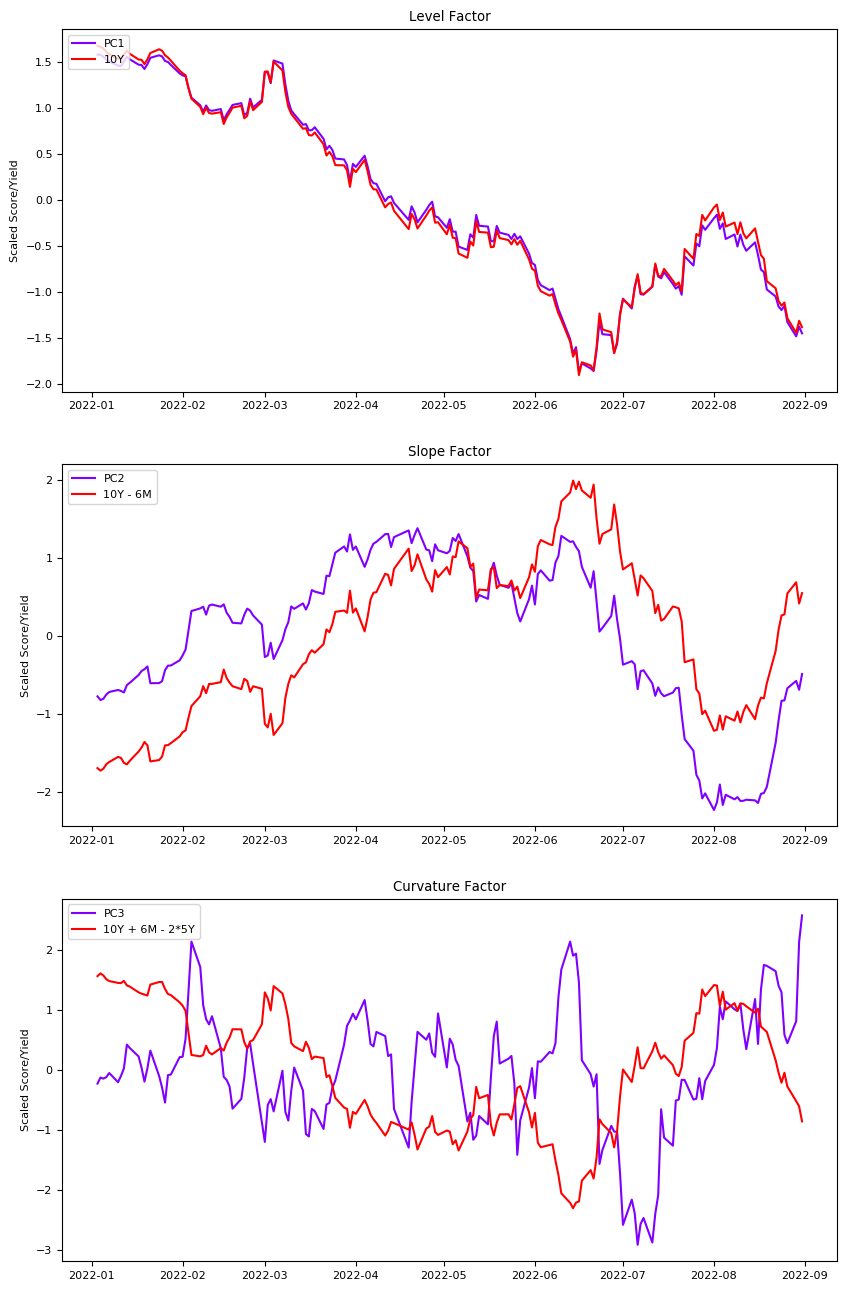

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,16))
colors = rainbow(["pca","actual"])

ax[0].plot(eig_scores_scaled["PC_1"], label="PC1", c=colors["pca"])
ax[1].plot(eig_scores_scaled["PC_2"], label="PC2", c=colors["pca"])
ax[2].plot(eig_scores_scaled["PC_3"], label="PC3", c=colors["pca"])

ax[0].plot(level, label="10Y", c=colors["actual"])
ax[1].plot(slope, label="10Y - 6M", c=colors["actual"])
ax[2].plot(curve, label="10Y + 6M - 2*5Y", c=colors["actual"])

ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

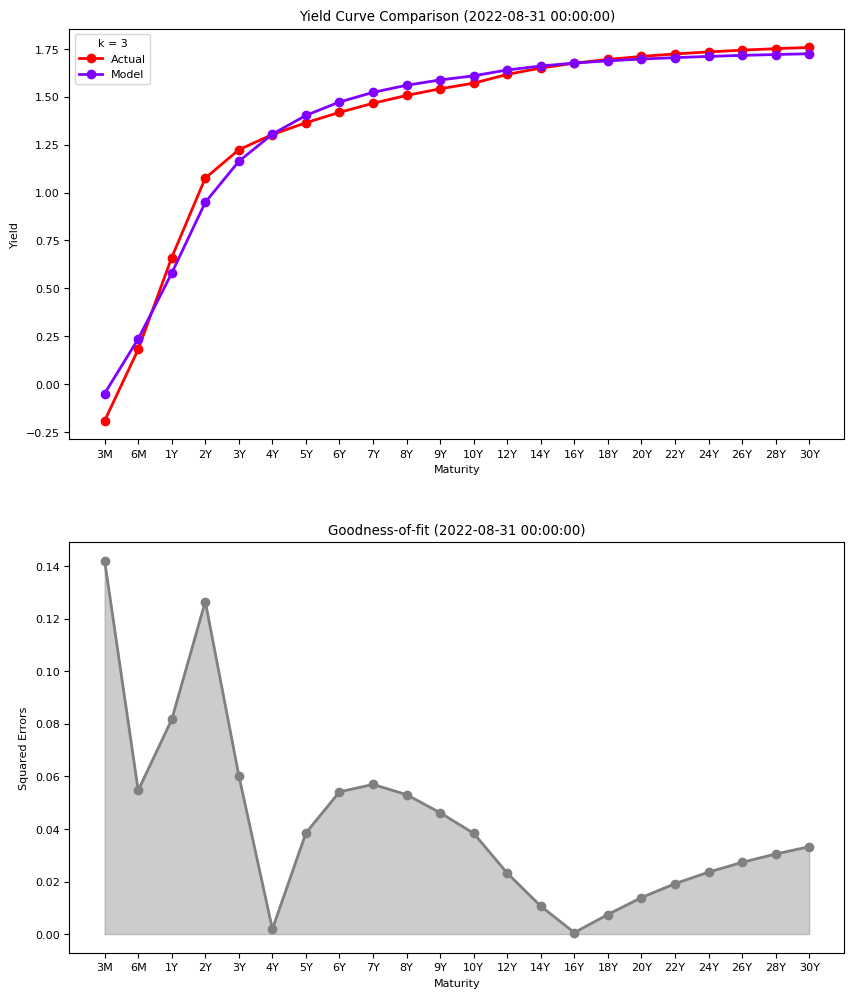

In [14]:
x = pca_rates.iloc[-1,:]
y = df_train.iloc[-1,:]
rse = np.sqrt((x-y)**2)

fig, ax = plt.subplots(nrows=2, figsize = (10,12))

ax[0].plot(y, label="Actual", c=colors["actual"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["pca"], linewidth=2, marker="o")

ax[1].plot(rse, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, rse, color="grey", alpha=0.4)

ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({df_train.index[-1]})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({df_train.index[-1]})")

ax[0].legend(title = "k = "+str(pca.k))
plt.subplots_adjust(hspace=0.25)
plt.show()

In [15]:
rmse_train = calc_rmse(df_train, pca_rates)
rmse_test = calc_rmse(df_test, pca_rates_oos)

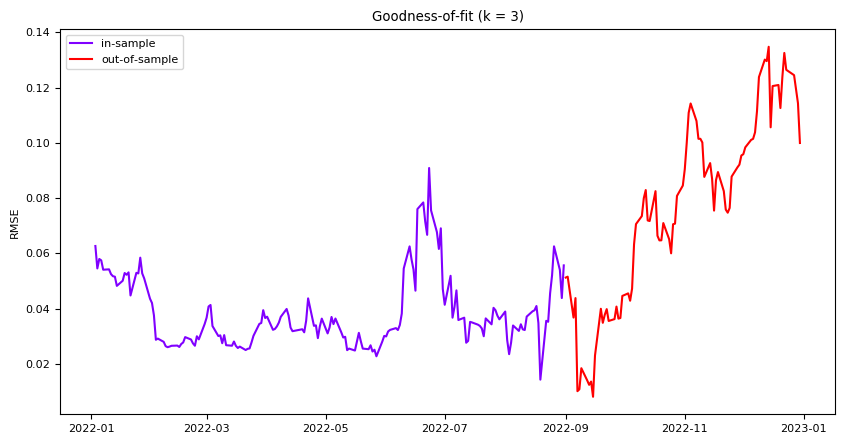

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(["in-sample","out-of-sample"])

ax.plot(rmse_train, c=color["in-sample"], label="in-sample")
ax.plot(rmse_test, c=color["out-of-sample"], label="out-of-sample")

ax.set_title ("Goodness-of-fit (k = "+ str(pca.k) + ")")
ax.set_ylabel ("RMSE")
ax.legend()

plt.show()

### Stationarity Analysis
***

The Augmented Dickey-Fuller (ADF) test can be applied, to statistically testify stationarity. Basically ADF runs a regression to forecast the first differences (Y) from on the original time series (X). The resulting t-statistic gives the ADF-statistic.
- <u>Stationary:</u> When t-stat is significant. A stationary time series would be mean-reverting immediately, enabling the original time to predict the next change.
- <u>Non-Stationary:</u> When t-stat is not significant. 

In [17]:
for i in eig_vectors.columns:
    print(i, adf_test(df=eig_scores, col=i, alpha=0.05))

PC_1 {'adf_stat': -0.9141, 'p_val': 0.7833, 'threshold': -2.8787, 'stationary': 'no'}
PC_2 {'adf_stat': -1.1496, 'p_val': 0.6949, 'threshold': -2.8787, 'stationary': 'no'}
PC_3 {'adf_stat': -2.8803, 'p_val': 0.0477, 'threshold': -2.8788, 'stationary': 'yes'}


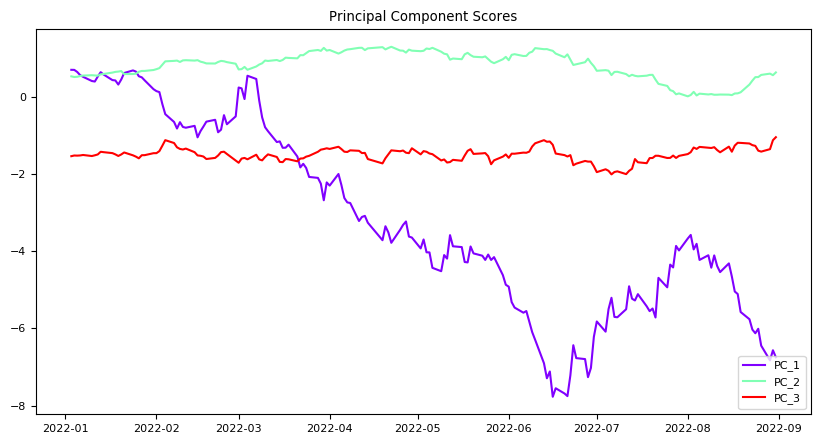

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
colors = rainbow(eig_scores.columns)

for i in pcs:
    plt.plot(eig_scores[i], c = colors[i], label = i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [19]:
lag = 10

/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


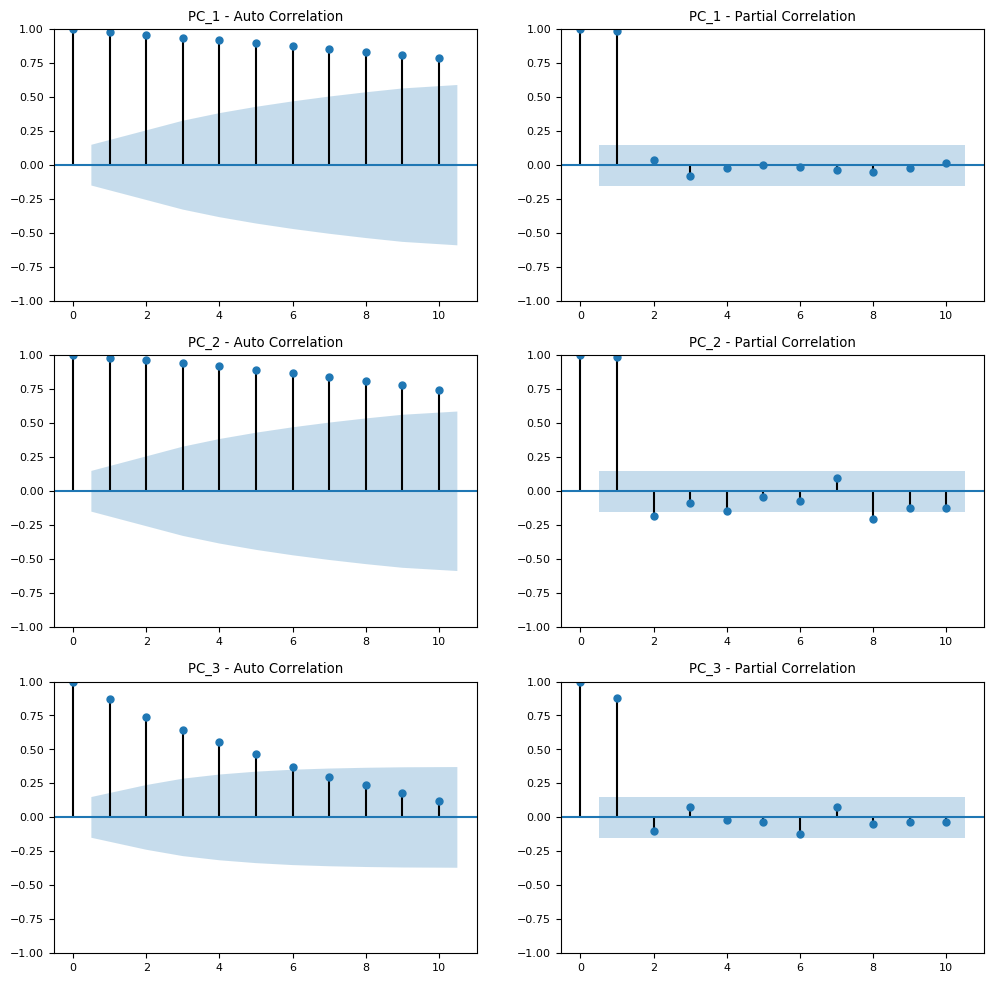

In [20]:
fig, ax = plt.subplots(nrows=pca.k, ncols=2, figsize=(12, 4*pca.k))

for i,j in enumerate (pcs):
    plot_acf (eig_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

In [21]:
periods = 1

eig_scores_diff = eig_scores.diff(periods).iloc[periods:].add_suffix("_diff")
eig_scores_diff.head()

,PC_1_diff,PC_2_diff,PC_3_diff
DATE,,,
2022-01-04,-0.001166,-0.016916,0.017584
2022-01-05,-0.053593,0.005549,-0.003053
2022-01-06,-0.082319,0.019536,0.004297
2022-01-07,-0.043668,0.011657,0.012111
2022-01-10,-0.109081,0.009128,-0.027010


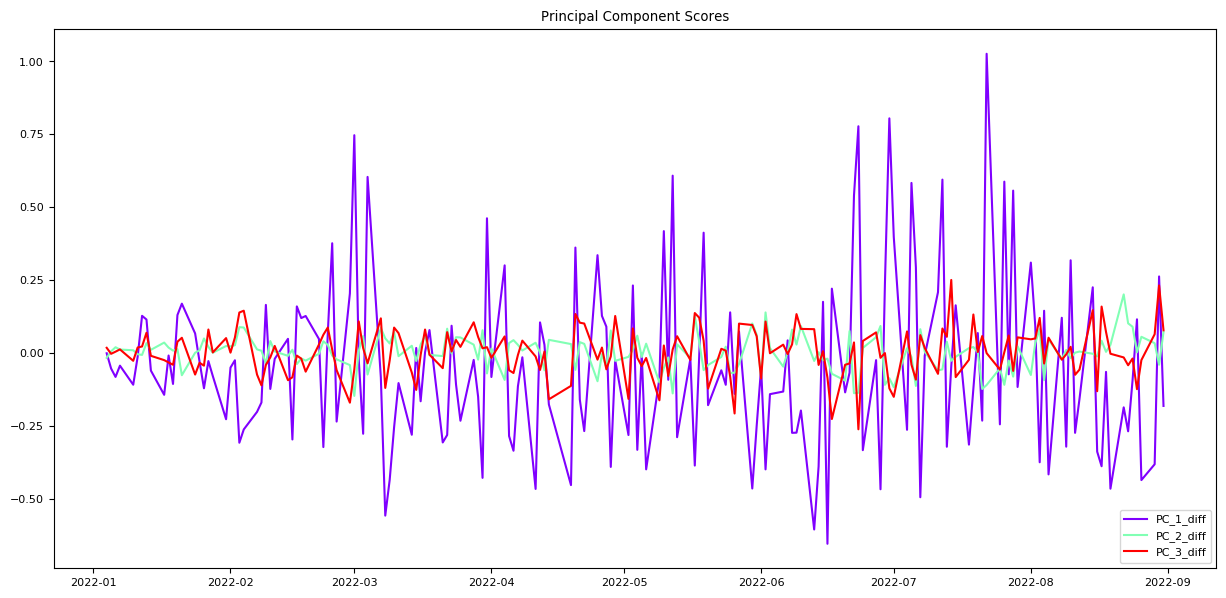

In [22]:
fig, ax = plt.subplots(figsize=(15,7))

colors = rainbow(eig_scores_diff.columns)

for i in eig_scores_diff.columns:
    plt.plot(eig_scores_diff[i], c=colors[i], label=i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [23]:
for i in eig_scores_diff.columns:
    print (i, adf_test(df=eig_scores_diff, col=i, alpha=0.05))

PC_1_diff {'adf_stat': -13.9584, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}
PC_2_diff {'adf_stat': -11.6631, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}
PC_3_diff {'adf_stat': -12.1377, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}


/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


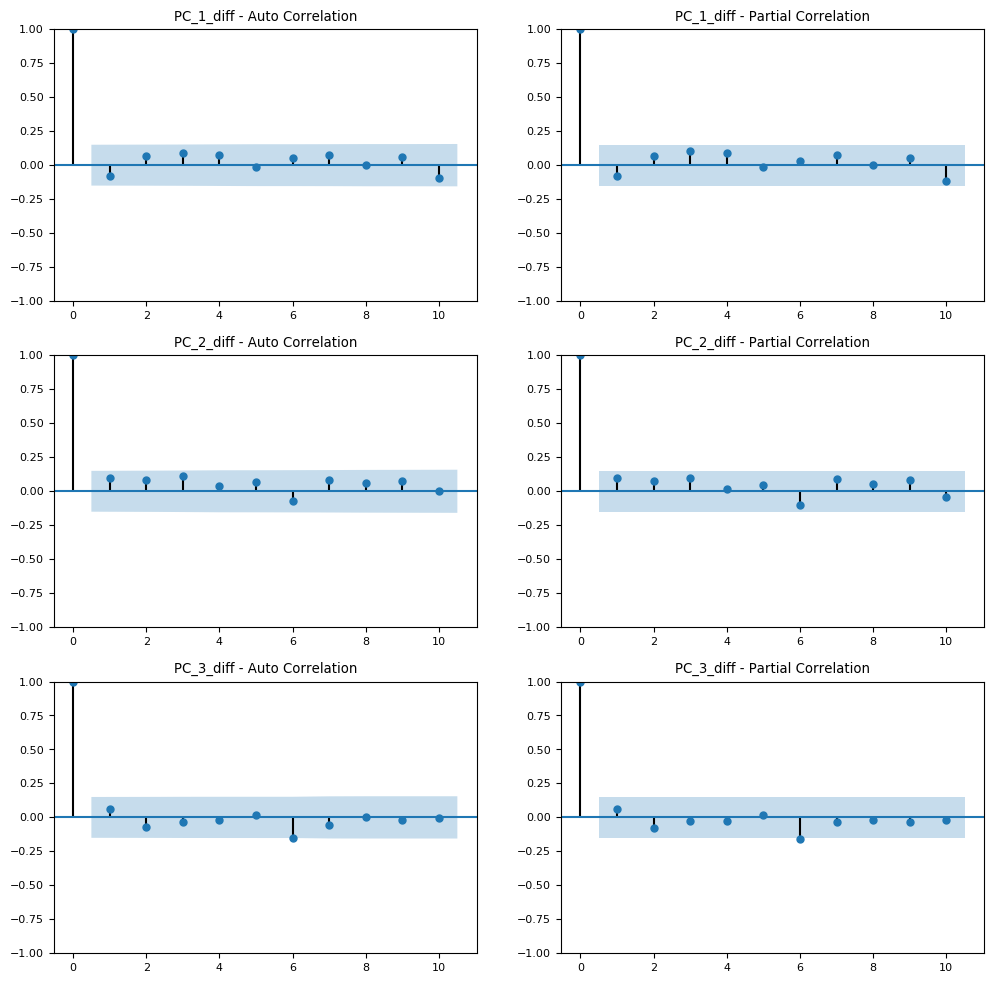

In [24]:
fig, ax = plt.subplots(nrows=pca.k, ncols=2, figsize=(12, 4*pca.k))

for i,j in enumerate (eig_scores_diff.columns):
    plot_acf (eig_scores_diff[j], lags=lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores_diff[j], lags=lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

### Stress Scenarios
***

In [76]:
eig_scores_up, eig_scores_down = pca.get_eig_scores_stress(sigma=2, n_days=30)

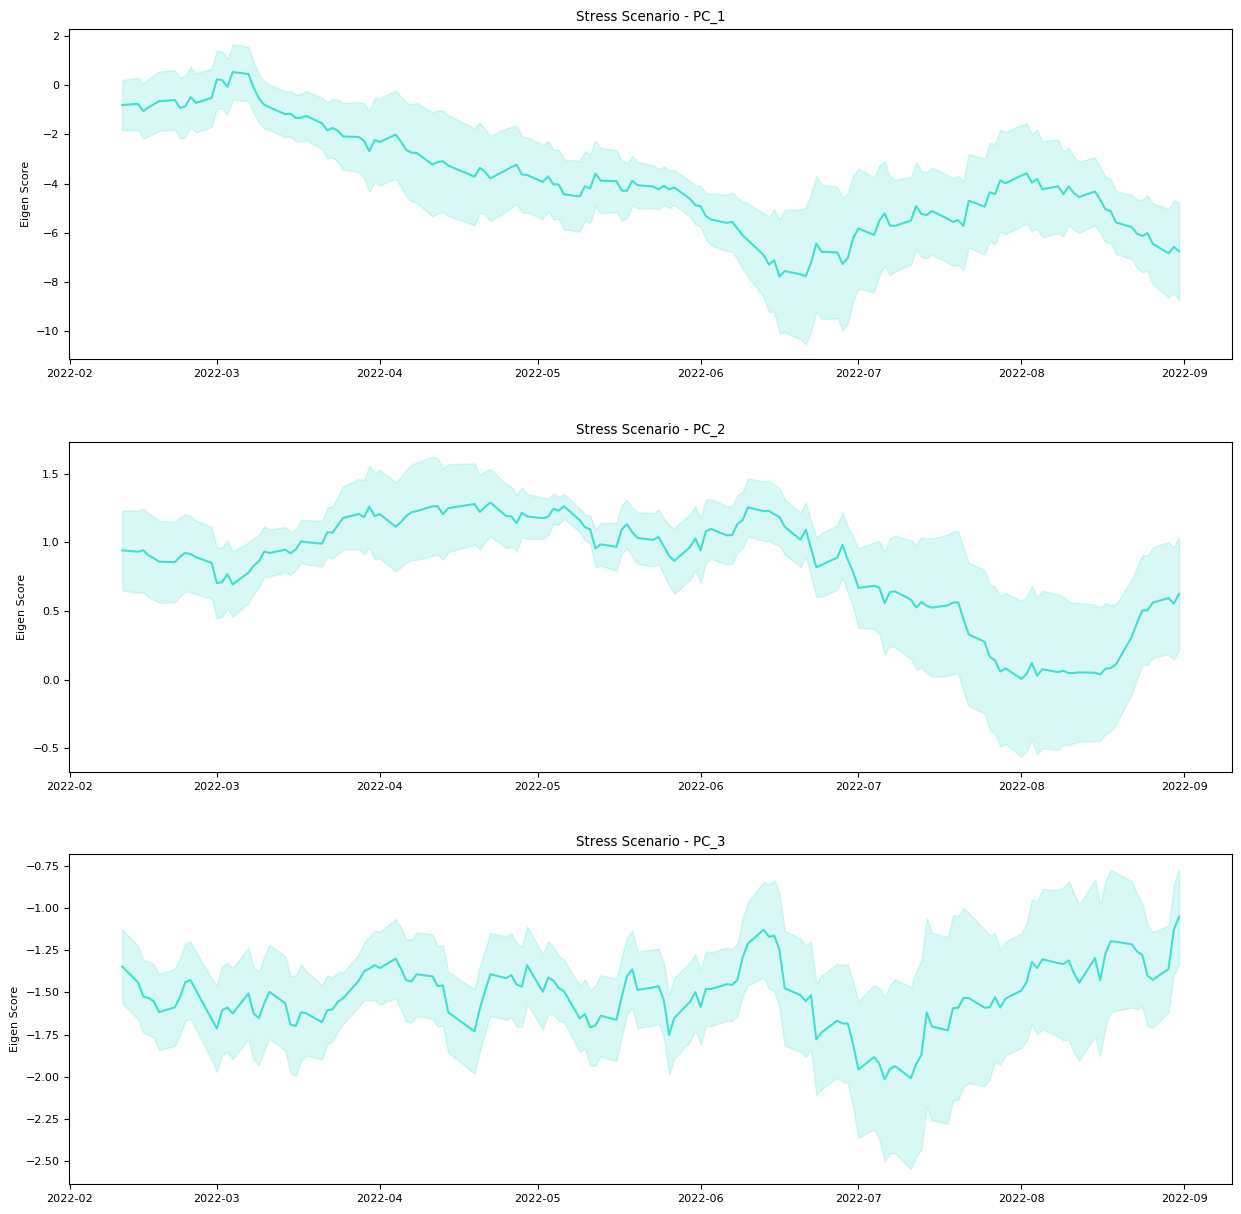

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
color = rainbow(["actual", "up", "down"])

for i,j in enumerate(pcs):
    ax[i].plot(eig_scores[j].iloc[n_days-1:], c="turquoise", label="actual", lw=1.5)
    ax[i].fill_between(
        x=eig_scores_down.index, 
        y1=eig_scores_down[j], 
        y2=eig_scores_up[j],
        alpha=0.2,
        color="turquoise"
    )

    ax[i].set_title (f'Stress Scenario - {j}')
    ax[i].set_ylabel ("Eigen Score")
    
plt.subplots_adjust(hspace=0.25)
plt.show()

In [66]:
stress_up_dic   = {i: pd.read_csv("../assets/stress/"+i.lower()+"_up.csv", index_col="DATE") for i in pcs}
stress_down_dic = {i: pd.read_csv("../assets/stress/"+i.lower()+"_down.csv", index_col="DATE") for i in pcs}

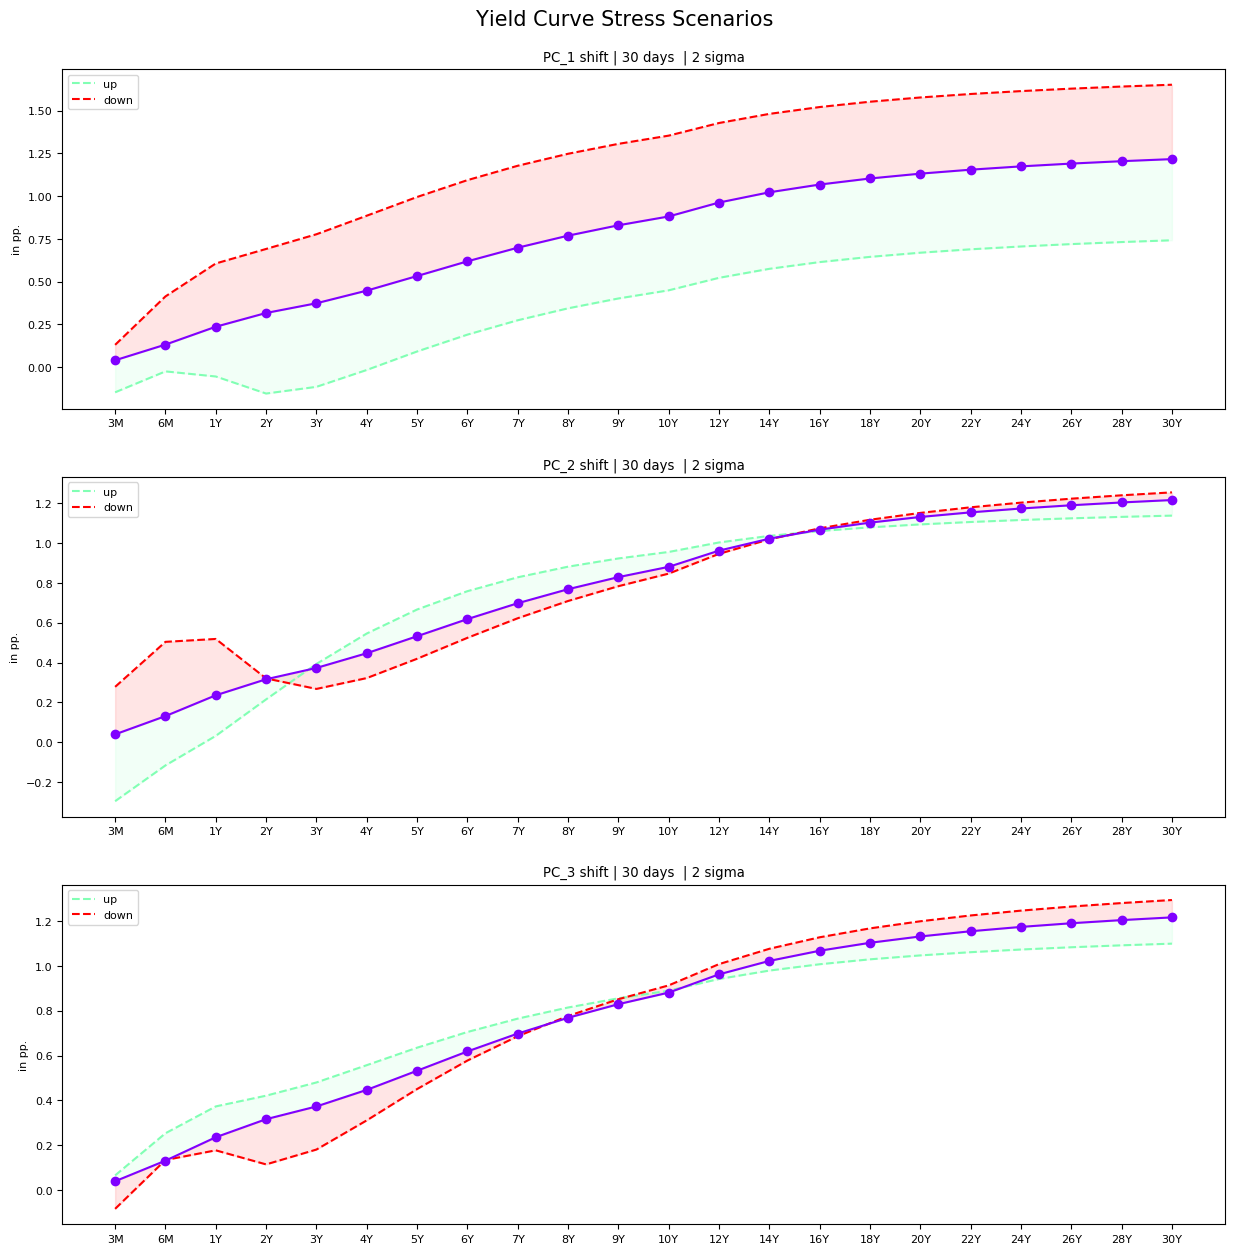

In [70]:
fig, ax = plt.subplots(nrows=pca.k, ncols=1, figsize = (pca.k*5,15))
fig.suptitle("Yield Curve Stress Scenarios", fontsize=15, y=0.92)
color = rainbow(["actual","up","down"])

idx = 20

for i,j in enumerate (pcs):
    up   = stress_up_dic[j].iloc[-idx]
    down = stress_down_dic[j].iloc[-idx]
    act  = df_train.iloc[-idx]
    
    ax[i].plot(up, label="up", c=color["up"], ls="--")
    ax[i].plot(down, label="down", c=color["down"], ls="--")
    ax[i].plot(act, c=color["actual"], marker="o")
    
    ax[i].fill_between(maturities_all, up, act, color = color["up"], alpha = 0.1)
    ax[i].fill_between(maturities_all, down, act, color = color["down"], alpha = 0.1)
    
    ax[i].set_ylabel("in pp.")
    ax[i].set_title("{} shift | {} days  | {} sigma".format(j, n_days, 2))
    ax[i].legend()

plt.show()